In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc # Added auc here
)

In [6]:
df = pd.read_csv('/content/train.csv')
display(df.head())

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15702656.0,Nwora,567.0,France,Male,33.0,9.0,0.0,2.0,1.0,0.0,156792.89,0.0
1,1,15647965.0,Yevdokimova,628.0,France,Female,38.0,3.0,0.0,1.0,1.0,1.0,51987.99,1.0
2,2,15798834.0,Ch'iu,635.0,France,Female,29.0,3.0,0.0,2.0,1.0,1.0,113079.19,0.0
3,3,15672056.0,Hsia,681.0,France,Male,28.0,6.0,0.0,2.0,1.0,0.0,14081.64,0.0
4,4,15759537.0,Okwudilichukwu,587.0,France,Female,27.0,5.0,0.0,2.0,1.0,0.0,158958.90,0.0


In [11]:
columns_to_drop = ['CustomerId', 'Surname']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)

In [10]:
df.isnull().sum()

,0
id,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0


In [12]:
categorical_cols = ['Geography', 'Gender']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
df_encoded.corr()['Exited'].abs().sort_values(ascending=False)

,Exited
Exited,1.000000
Age,0.449425
NumOfProducts,0.312812
Geography_Germany,0.242651
IsActiveMember,0.188748
Gender_Male,0.169465
Balance,0.160062
Geography_Spain,0.061859
CreditScore,0.052375
EstimatedSalary,0.035193


In [13]:
categorical_cols = ['Geography', 'Gender']

df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
scaler=StandardScaler()
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [16]:
rf_model = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=5,
random_state=42)

In [17]:
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='f1')
print("Cross-Validation Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.71559633 0.66666667 0.69975787 0.70079636 0.67148014]
Mean F1 Score: 0.6908594740190107


In [18]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [19]:
y_pred=rf_model.predict(X_test_scaled)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2424
         1.0       0.78      0.63      0.70       576

    accuracy                           0.90      3000
   macro avg       0.85      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



Text(70.72222222222221, 0.5, 'True Labels')

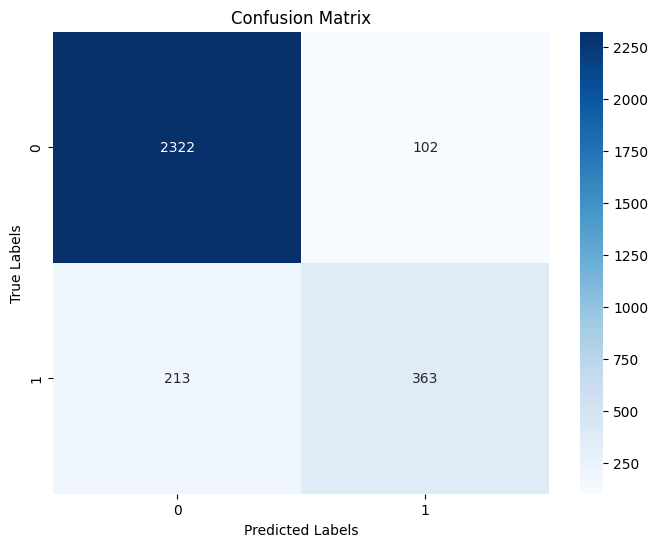

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [22]:
importance=rf_model.feature_importances_
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'importance': importance
})
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
print(feature_imp)

              Feature  importance
2                 Age    0.364977
5       NumOfProducts    0.235074
4             Balance    0.075212
1         CreditScore    0.053307
7      IsActiveMember    0.052723
8     EstimatedSalary    0.052473
9   Geography_Germany    0.050181
0                  id    0.047131
11        Gender_Male    0.029523
3              Tenure    0.028428
6           HasCrCard    0.005603
10    Geography_Spain    0.005369


In [23]:
feature_imp.head()

,Feature,importance
2,Age,0.364977
5,NumOfProducts,0.235074
4,Balance,0.075212
1,CreditScore,0.053307
7,IsActiveMember,0.052723


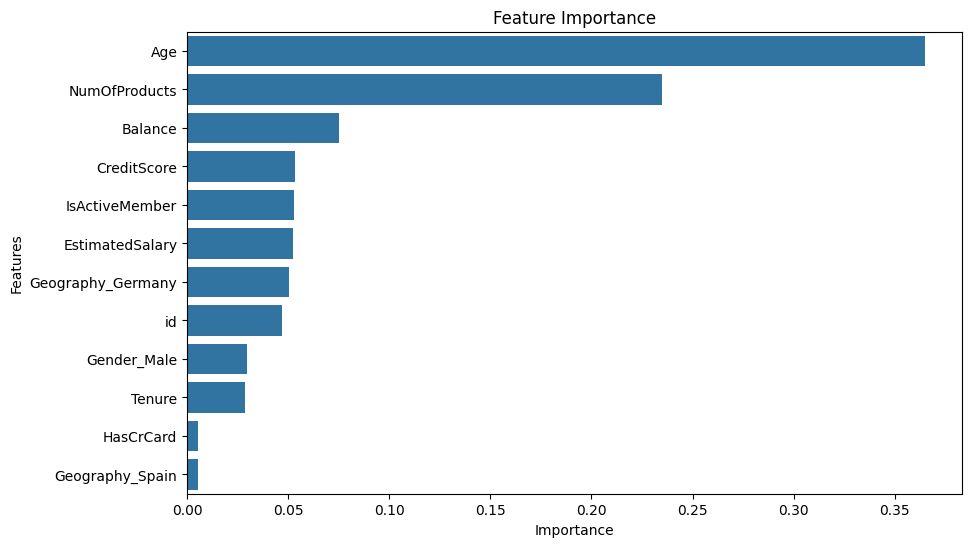

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='Feature', data=feature_imp)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout
plt.show()

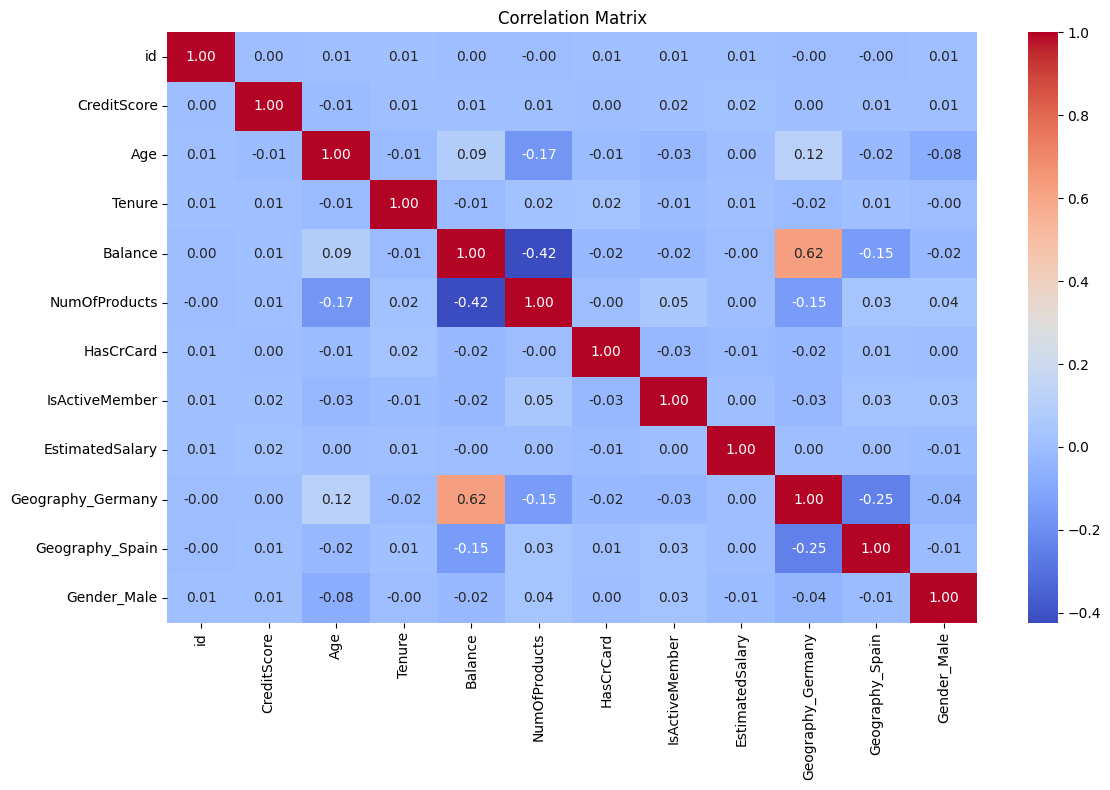

In [25]:
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



In [26]:
y_pred_proba=rf_model.predict_proba(X_test_scaled)[:,1]
fpr,tpr,_=roc_curve(y_test,y_pred_proba)
roc_auc=auc(fpr,tpr)

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

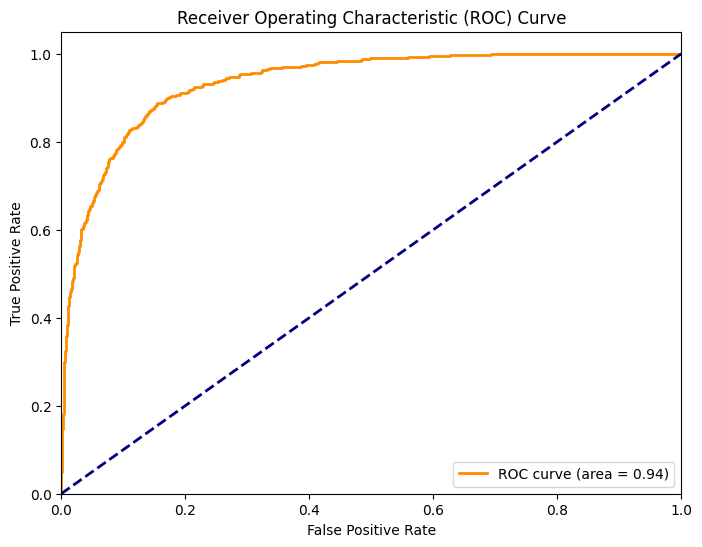

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')
